In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [12]:
unemployment_df = pd.read_csv('variables_of_interest/unemployment_by_sector.csv')
etf_df = pd.read_csv('variables_of_interest/normalized_etf_monthly_pivot.csv')
unemployment_df = unemployment_df.rename(columns={'year' : 'Year', 'month' : 'Month'})
unemployment_df

,Year,Month,unemployment,category
0,2014,1,7.8,retail
1,2014,2,7.6,retail
2,2014,3,6.8,retail
3,2014,4,5.9,retail
4,2014,5,6.4,retail
...,...,...,...,...
630,2024,3,7.1,agricultural
631,2024,4,5.4,agricultural
632,2024,5,7.3,agricultural
633,2024,6,4.3,agricultural


In [15]:
etf_df = etf_df.drop(columns=['Unnamed: 0'])
etf_df

,Year,Month,Agri_Machinery_ETF,Food_Beverage_ETF,Investment_Funds_ETF,Restaurant_FastFood_ETF,Retail_ETF
0,1999,11,36.835142,40.019708,125.522357,34.920701,17.868213
1,1999,12,34.957983,37.129539,129.629927,32.392583,14.447012
2,2000,1,37.142867,35.526435,129.359423,30.139771,15.766343
3,2000,2,31.221460,32.619976,123.136288,28.223431,16.672860
4,2000,3,29.319403,31.920499,127.442178,29.358011,18.823416
...,...,...,...,...,...,...,...
287,2023,10,253.592562,316.868611,329.718627,1142.686074,198.630677
288,2023,11,249.251962,342.498279,345.688258,1314.577751,199.673985
289,2023,12,264.998565,407.599971,366.626038,1415.650851,214.157736
290,2024,1,273.865412,425.311863,376.130457,1438.604583,224.549750


In [48]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_xgboost(data, target, n_train=36, n_test=12):
    features = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

    data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

    data[features + [target]] = data[features + [target]].astype(float)

    # Create lagged features
    def add_lagged_features(df, features, lags=[1, 2, 3]):
        for lag in lags:
            for feature in features:
                df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
        return df

    lags = [1, 2, 3]
    data = add_lagged_features(data, features, lags)

    data.dropna(inplace=True)

    lagged_features = [f'{feature}_lag{lag}' for feature in features for lag in lags]

    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data[lagged_features + [target]])

    scaled_df = pd.DataFrame(scaled_data, columns=lagged_features + [target])
    scaled_df['Date'] = data['Date'].values

    def walk_forward_validation(data, n_train, n_test):
        predictions = []
        actuals = []
        dates = []
        feature_importances = []

        for i in range(n_train, len(data) - n_test, n_test):
            train, test = data[i - n_train:i], data[i:i + n_test]
            
            X_train, y_train = train[lagged_features].values, train[target].values
            X_test, y_test = test[lagged_features].values, test[target].values

            model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(lagged_features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
            y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), len(lagged_features))), y_pred.reshape(-1, 1)), axis=1))[:, -1]

            predictions.extend(y_pred_inv)
            actuals.extend(y_test_inv)
            dates.extend(test['Date'].values)

            feature_importances.append(model.feature_importances_)

        return np.array(predictions), np.array(actuals), np.array(dates), np.mean(feature_importances, axis=0)

    predictions, actuals, dates, feature_importances = walk_forward_validation(scaled_df, n_train, n_test)

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")

    plt.figure(figsize=(15, 5))
    plt.plot(dates, actuals, color='blue', label='Actual values')
    plt.plot(dates, predictions, color='red', label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

    feature_importance_df = pd.DataFrame({'Feature': lagged_features, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    plt.figure(figsize=(15, 5))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    # etf_columns = ['Agri_Machinery_ETF', 'Food_Beverage_ETF', 'Restaurant_FastFood_ETF', 'Retail_ETF']

     Year  Month  unemployment  Agri_Machinery_ETF  Food_Beverage_ETF  \
0    2014      1           7.8           98.150502          63.728504   
1    2014      2           7.6           96.821312          63.786343   
2    2014      3           6.8           98.684562          67.985735   
3    2014      4           5.9          101.809048          67.423284   
4    2014      5           6.4          103.585188          66.924597   
..    ...    ...           ...                 ...                ...   
117  2023     10           4.0          253.592562         316.868611   
118  2023     11           3.6          249.251962         342.498279   
119  2023     12           4.0          264.998565         407.599971   
120  2024      1           4.6          273.865412         425.311863   
121  2024      2           4.7          277.317478         421.236543   

     Investment_Funds_ETF  Restaurant_FastFood_ETF  Retail_ETF  
0              168.634973               299.662337   71.75

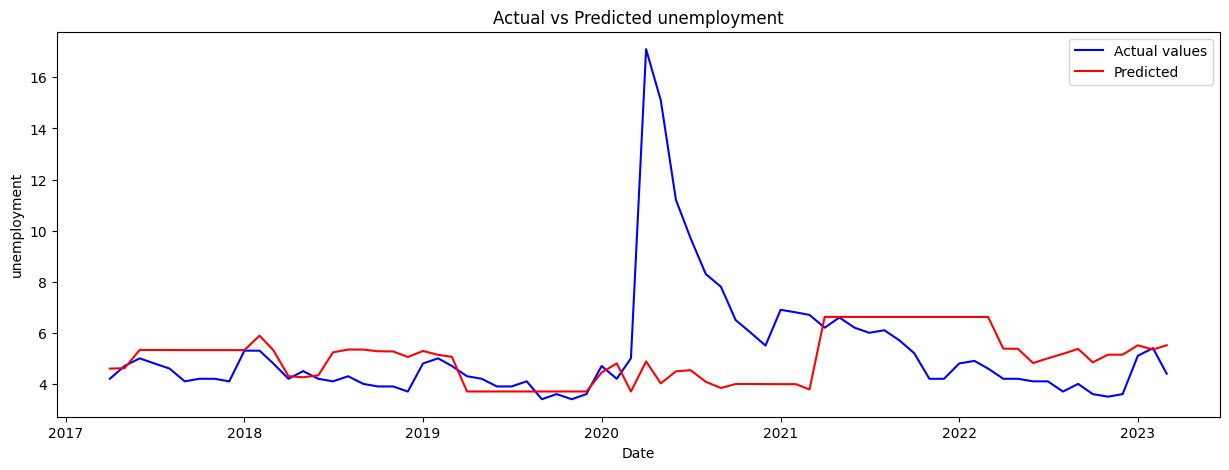

                         Feature  Importance
0        Agri_Machinery_ETF_lag1    0.167961
9                Retail_ETF_lag1    0.163518
6   Restaurant_FastFood_ETF_lag1    0.154341
3         Food_Beverage_ETF_lag1    0.104483
11               Retail_ETF_lag3    0.091218
2        Agri_Machinery_ETF_lag3    0.076313
1        Agri_Machinery_ETF_lag2    0.076295
5         Food_Beverage_ETF_lag3    0.054019
4         Food_Beverage_ETF_lag2    0.041506
8   Restaurant_FastFood_ETF_lag3    0.035188
7   Restaurant_FastFood_ETF_lag2    0.029270
10               Retail_ETF_lag2    0.005888


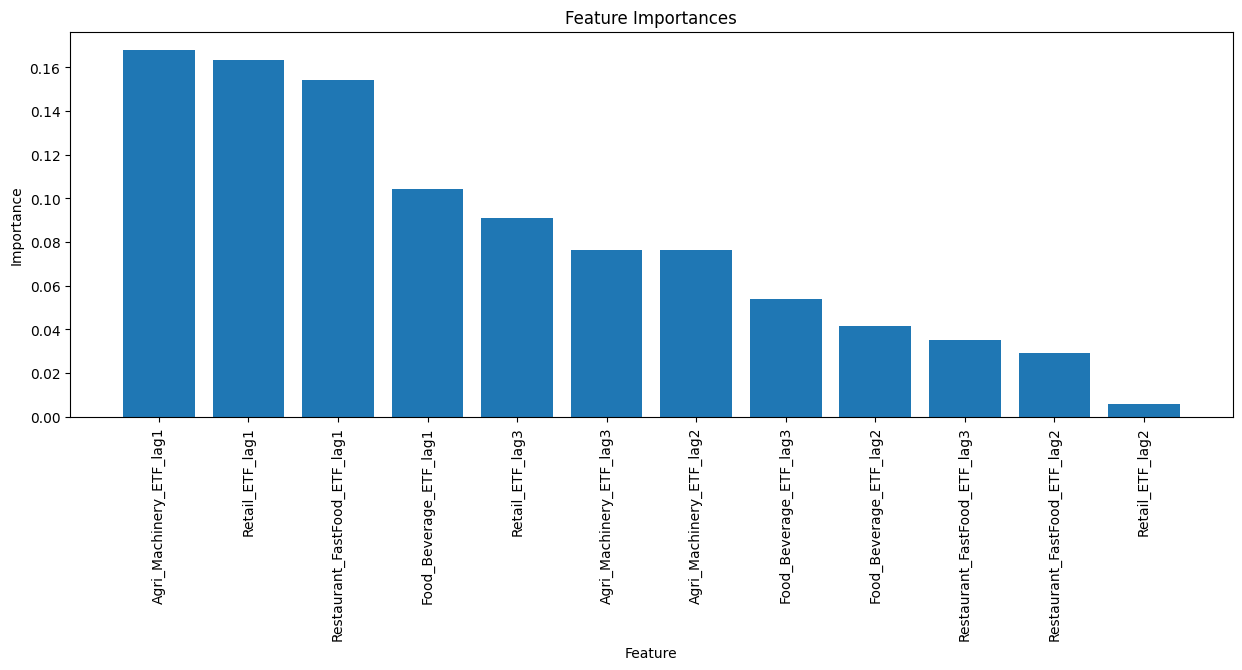

     Year  Month  unemployment  Agri_Machinery_ETF  Food_Beverage_ETF  \
0    2014      1           6.4           98.150502          63.728504   
1    2014      2           6.9           96.821312          63.786343   
2    2014      3           6.2           98.684562          67.985735   
3    2014      4           6.1          101.809048          67.423284   
4    2014      5           5.5          103.585188          66.924597   
..    ...    ...           ...                 ...                ...   
117  2023     10           2.8          253.592562         316.868611   
118  2023     11           3.5          249.251962         342.498279   
119  2023     12           4.6          264.998565         407.599971   
120  2024      1           4.2          273.865412         425.311863   
121  2024      2           3.4          277.317478         421.236543   

     Investment_Funds_ETF  Restaurant_FastFood_ETF  Retail_ETF  
0              168.634973               299.662337   71.75

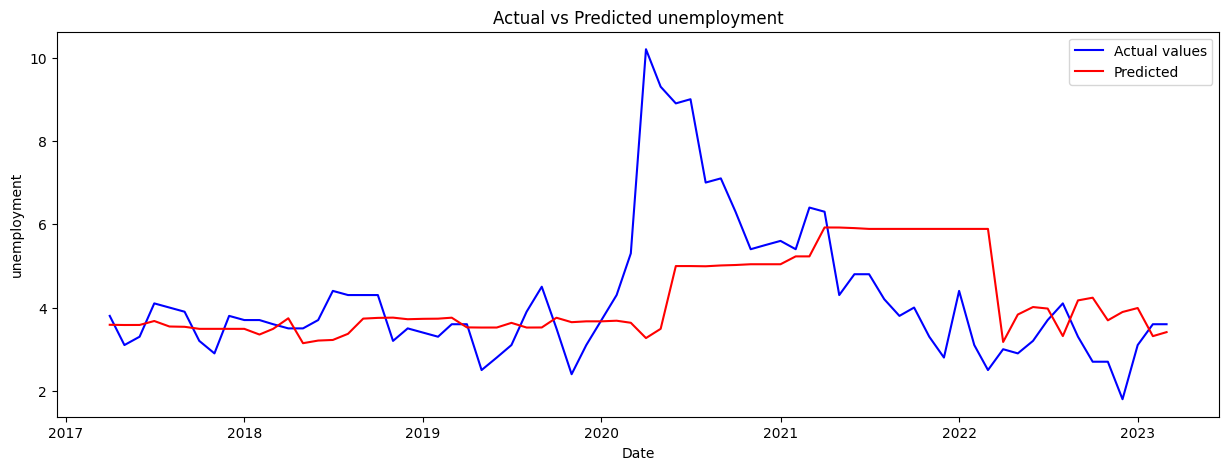

                         Feature  Importance
6   Restaurant_FastFood_ETF_lag1    0.243267
4         Food_Beverage_ETF_lag2    0.171722
9                Retail_ETF_lag1    0.105725
2        Agri_Machinery_ETF_lag3    0.099424
11               Retail_ETF_lag3    0.086624
0        Agri_Machinery_ETF_lag1    0.081658
5         Food_Beverage_ETF_lag3    0.055543
8   Restaurant_FastFood_ETF_lag3    0.042078
7   Restaurant_FastFood_ETF_lag2    0.031532
10               Retail_ETF_lag2    0.029641
1        Agri_Machinery_ETF_lag2    0.026971
3         Food_Beverage_ETF_lag1    0.025813


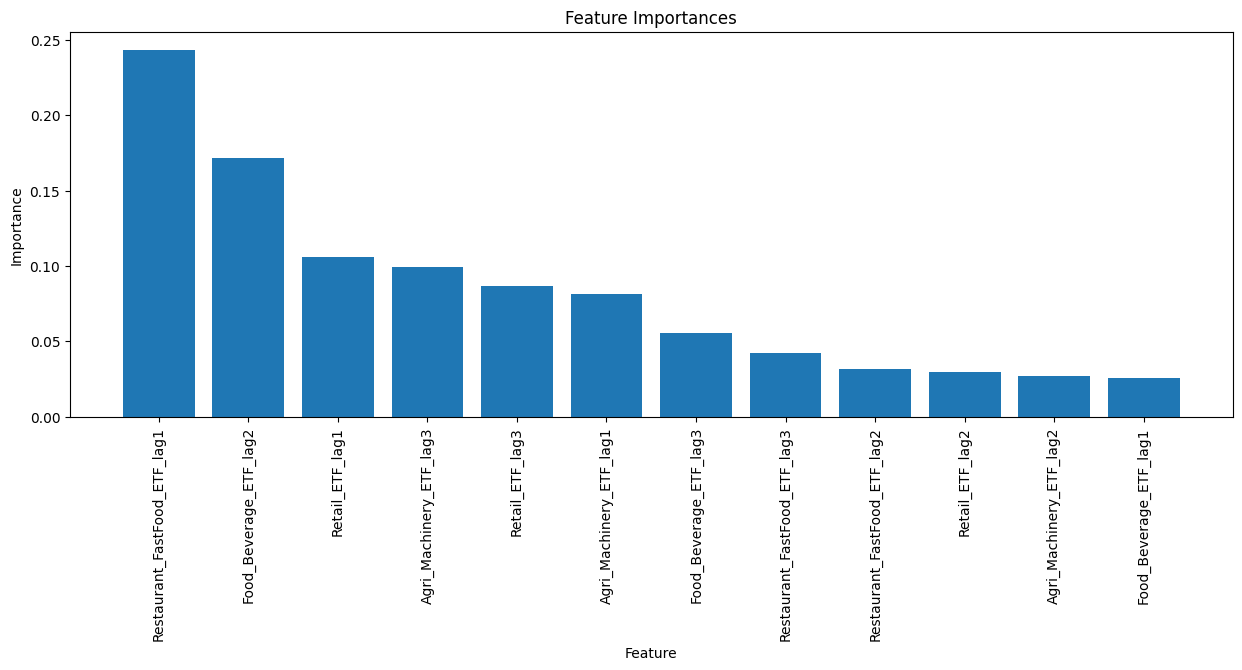

     Year  Month  unemployment  Agri_Machinery_ETF  Food_Beverage_ETF  \
0    2014      1           7.0           98.150502          63.728504   
1    2014      2           7.0           96.821312          63.786343   
2    2014      3           6.8           98.684562          67.985735   
3    2014      4           5.9          101.809048          67.423284   
4    2014      5           6.1          103.585188          66.924597   
..    ...    ...           ...                 ...                ...   
117  2023     10           3.6          253.592562         316.868611   
118  2023     11           3.5          249.251962         342.498279   
119  2023     12           3.5          264.998565         407.599971   
120  2024      1           4.1          273.865412         425.311863   
121  2024      2           4.2          277.317478         421.236543   

     Investment_Funds_ETF  Restaurant_FastFood_ETF  Retail_ETF  
0              168.634973               299.662337   71.75

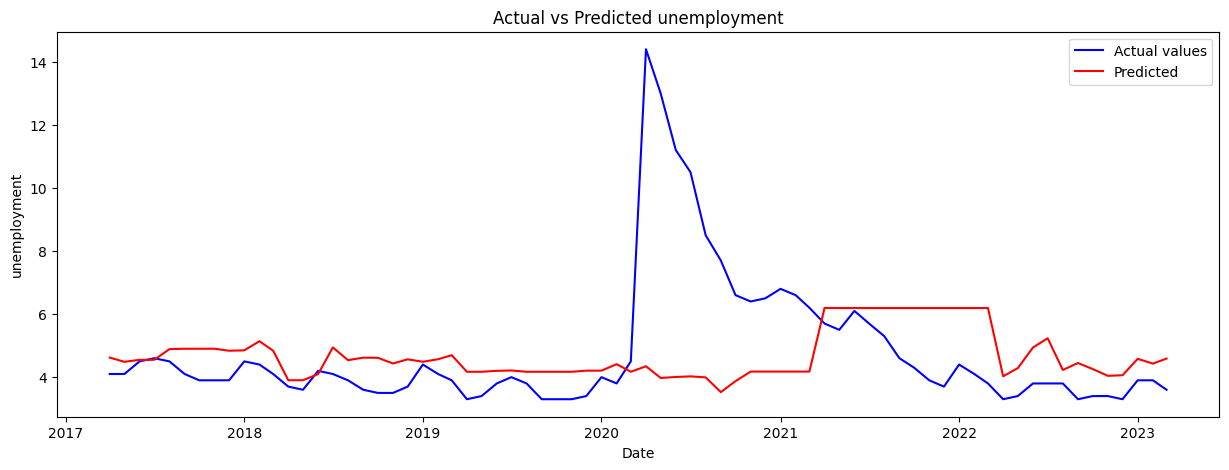

                         Feature  Importance
9                Retail_ETF_lag1    0.207957
6   Restaurant_FastFood_ETF_lag1    0.191194
0        Agri_Machinery_ETF_lag1    0.166822
3         Food_Beverage_ETF_lag1    0.130391
4         Food_Beverage_ETF_lag2    0.106272
1        Agri_Machinery_ETF_lag2    0.066769
2        Agri_Machinery_ETF_lag3    0.045344
11               Retail_ETF_lag3    0.025267
7   Restaurant_FastFood_ETF_lag2    0.021092
5         Food_Beverage_ETF_lag3    0.015597
10               Retail_ETF_lag2    0.012260
8   Restaurant_FastFood_ETF_lag3    0.011035


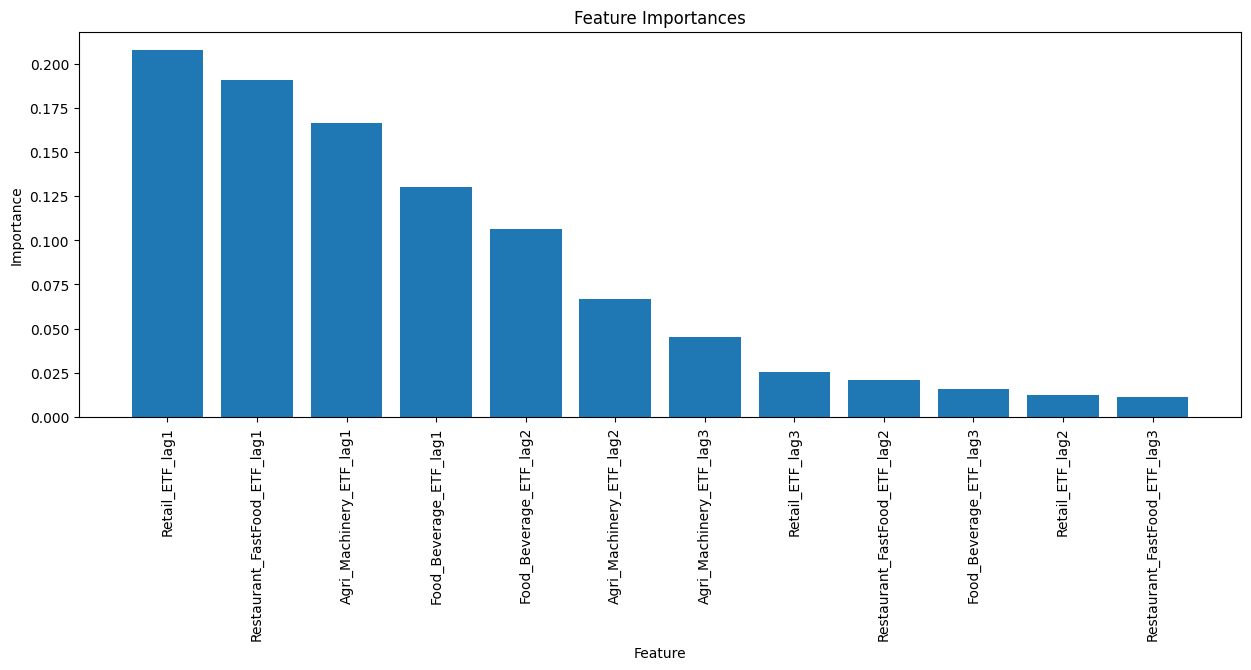

     Year  Month  unemployment  Agri_Machinery_ETF  Food_Beverage_ETF  \
0    2014      1           9.5           98.150502          63.728504   
1    2014      2          10.3           96.821312          63.786343   
2    2014      3          10.2           98.684562          67.985735   
3    2014      4           8.0          101.809048          67.423284   
4    2014      5           8.1          103.585188          66.924597   
..    ...    ...           ...                 ...                ...   
117  2023     10           5.5          253.592562         316.868611   
118  2023     11           5.5          249.251962         342.498279   
119  2023     12           4.8          264.998565         407.599971   
120  2024      1           6.0          273.865412         425.311863   
121  2024      2           5.9          277.317478         421.236543   

     Investment_Funds_ETF  Restaurant_FastFood_ETF  Retail_ETF  
0              168.634973               299.662337   71.75

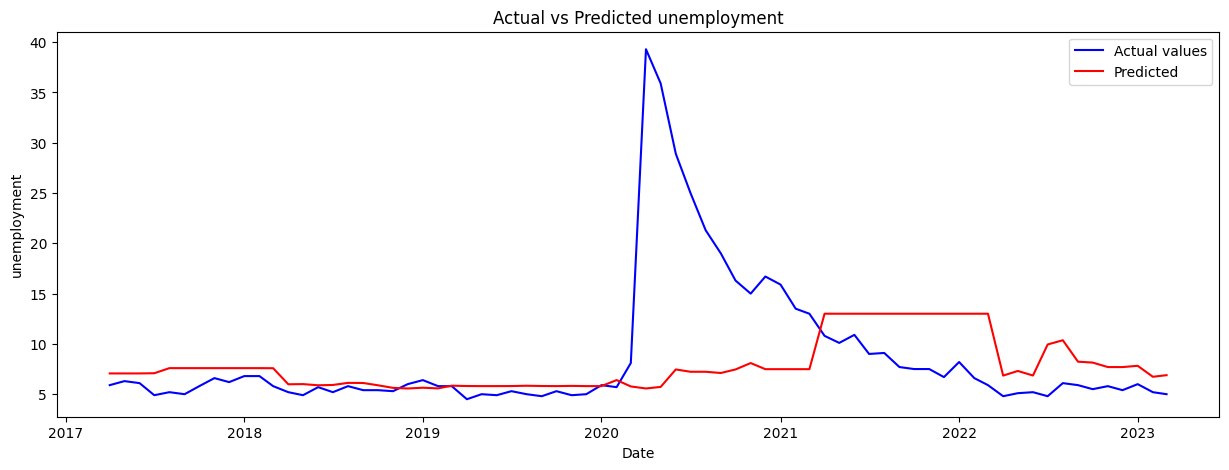

                         Feature  Importance
6   Restaurant_FastFood_ETF_lag1    0.228791
0        Agri_Machinery_ETF_lag1    0.183880
8   Restaurant_FastFood_ETF_lag3    0.164766
3         Food_Beverage_ETF_lag1    0.156502
1        Agri_Machinery_ETF_lag2    0.052387
7   Restaurant_FastFood_ETF_lag2    0.048522
4         Food_Beverage_ETF_lag2    0.045436
2        Agri_Machinery_ETF_lag3    0.038552
5         Food_Beverage_ETF_lag3    0.024098
10               Retail_ETF_lag2    0.022225
11               Retail_ETF_lag3    0.020369
9                Retail_ETF_lag1    0.014472


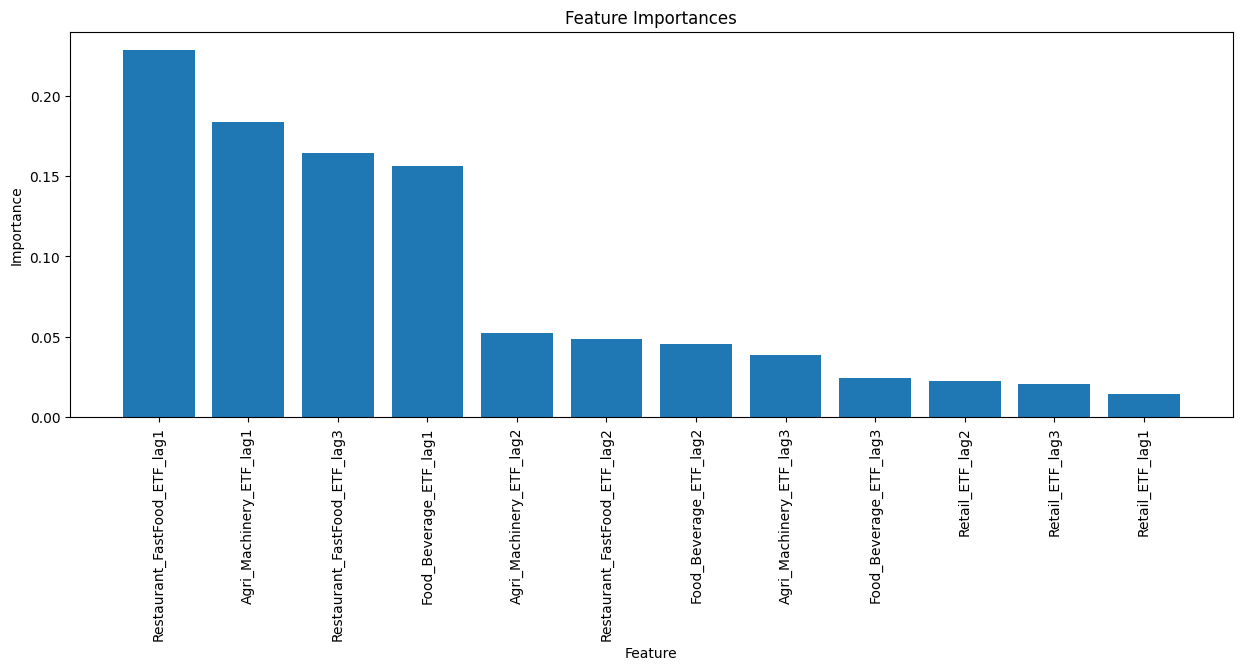

     Year  Month  unemployment  Agri_Machinery_ETF  Food_Beverage_ETF  \
0    2014      1          13.0           98.150502          63.728504   
1    2014      2          11.4           96.821312          63.786343   
2    2014      3          14.9           98.684562          67.985735   
3    2014      4          11.0          101.809048          67.423284   
4    2014      5           7.4          103.585188          66.924597   
..    ...    ...           ...                 ...                ...   
117  2023     10           6.7          253.592562         316.868611   
118  2023     11           6.6          249.251962         342.498279   
119  2023     12           7.0          264.998565         407.599971   
120  2024      1           8.0          273.865412         425.311863   
121  2024      2           9.0          277.317478         421.236543   

     Investment_Funds_ETF  Restaurant_FastFood_ETF  Retail_ETF  
0              168.634973               299.662337   71.75

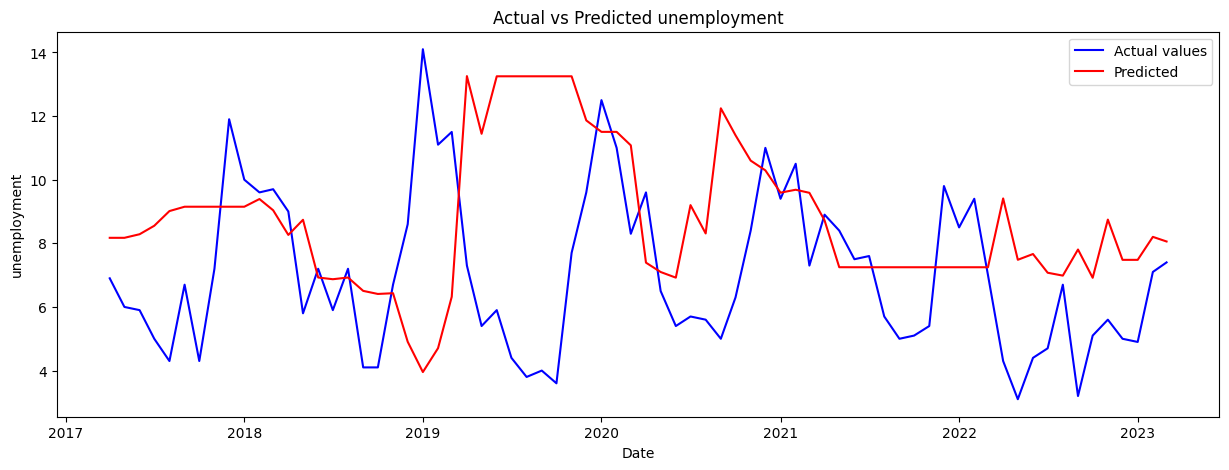

                         Feature  Importance
1        Agri_Machinery_ETF_lag2    0.152303
8   Restaurant_FastFood_ETF_lag3    0.146050
11               Retail_ETF_lag3    0.135378
9                Retail_ETF_lag1    0.121876
10               Retail_ETF_lag2    0.091780
6   Restaurant_FastFood_ETF_lag1    0.085815
4         Food_Beverage_ETF_lag2    0.084891
2        Agri_Machinery_ETF_lag3    0.081122
5         Food_Beverage_ETF_lag3    0.037791
0        Agri_Machinery_ETF_lag1    0.029571
3         Food_Beverage_ETF_lag1    0.017513
7   Restaurant_FastFood_ETF_lag2    0.015910


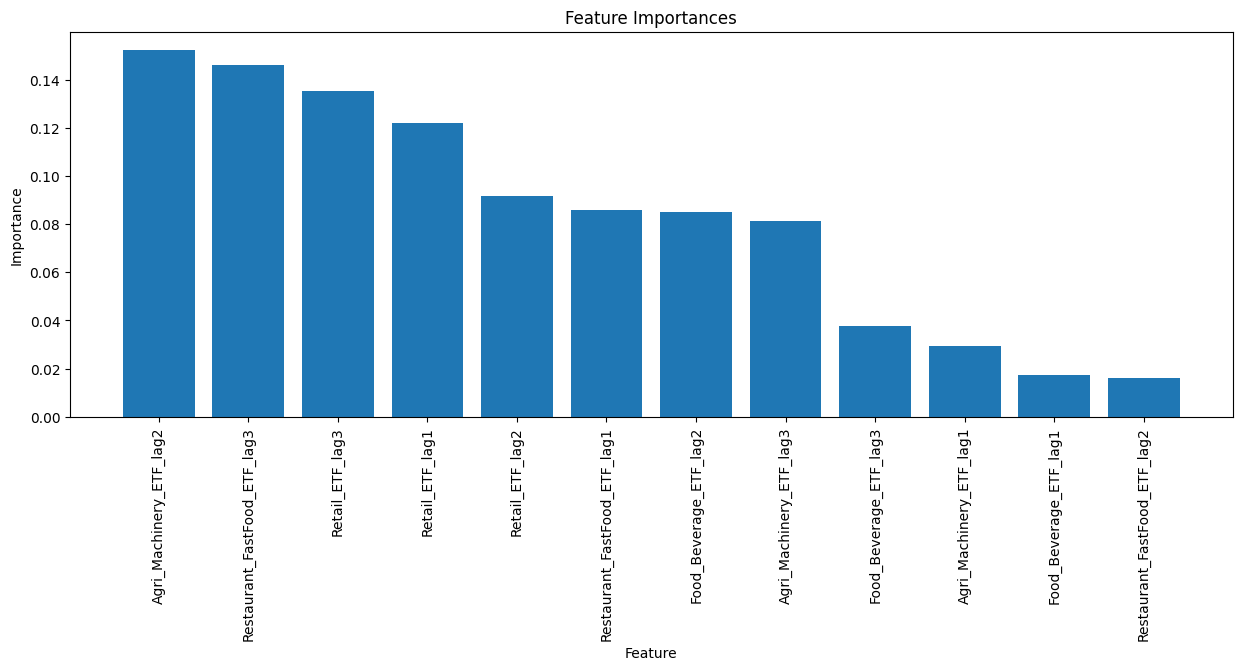

In [49]:
for category in unemployment_df['category'].unique():
    temp = unemployment_df[unemployment_df['category'] == category]
    temp = temp.drop(columns=['category'])
    
    df = pd.merge(temp, etf_df, on=['Year', 'Month'], how='inner')
    print(df)
    print(f'Results for {category}')
    train_xgboost(df, 'unemployment')
     
    